
**Part-2: Connectionist Methods**

**1.	Background and Dataset**
The garment industry is one of the key examples of the industrial globalization of this modern era. There are many manual operations in this business, which requires a lot of effort. Employee performance in terms of production and delivery in clothing manufacturing enterprises is a major factor in meeting the enormous demand for textile products around the world. Hence, monitoring, evaluating, and forecasting the productivity performance of the factory work teams is highly desired by the decision-makers in the garment business.
In this study, you will use Productivity Prediction of Garment Employees dataset to classify it as satisfactory or unsatisfactory productivity.
The dataset consists of 1197 instances and 15 features. For dataset description see UCI Machine Leaning Library at:  https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees

This study consists of two main tasks:
*   Task 1 (A-D, below) is about implementing and training a multilayer feedforward neural network to classify productivity data as satisfactory or unsatisfactory.
*   Task 2 (E-G) is about applying computational intelligence techniques to classify the data based on various features.




**Information about the dataset:**

*   01	date			:	Date in MM-DD-YYYY
*   02	day			:	Day of the Week
*   03	quarter			:	A portion of the month. A month was divided into four quarters
*   04	department		:	Associated department with the instance
*   05	team_no			:	Associated team number with the instance
*   06	no_of_workers		:	Number of workers in each team
*   07	no_of_style_change	:	Number of changes in the style of a particular product
*   08	targeted_productivity	:	Targeted productivity set by the Authority for each team for each day
*   09	smv			:	Standard Minute Value, it is the allocated time for a task
*   10	wip			:	Work in progress. Includes the number of unfinished items for products
*   11	over_time		:	Represents the amount of overtime by each team in minutes
*   12	incentive		:	Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
*   13	idle_time		:	The amount of time when the production was interrupted due to several reasons
*   14	idle_men		:	The number of workers who were idle due to production interruption
*   15	actual_productivity	:	The actual % of productivity that was delivered by the workers. It ranges from 0-1.

**TASK 1 (A-D)**

**A. Dataset Preperation**

2.1	The original class label (actual_productivity) is a continuous variable. You must first transform it to a discrete variable so that you can apply **Binary Classification** on it. **Visualize** the distribution of features and classes, **normalize** the data, and **divide** it into training and test sets.

In [1]:
# import required libraries
import requests
from zipfile import ZipFile
import pandas as pd
from io import BytesIO, TextIOWrapper
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

In [2]:
# conect to UCI Machine Leaning Library retrieve and extract zip file contents to a Pandas DataFrame

# URL of the zip file
url = "https://archive.ics.uci.edu/static/public/597/productivity+prediction+of+garment+employees.zip"

# send a GET request to the URL
response = requests.get(url)

# check if the request was successful
if response.status_code == 200:
    # read the content of the zip file
    zip_content = BytesIO(response.content)

    # open the zip file
    with ZipFile(zip_content, 'r') as zip_file:
        # retrieve contained CSV filename
        csv_filename = zip_file.namelist()[0]

        # open the CSV file in the zip file
        with zip_file.open(csv_filename) as csv_file:
            # wrap the CSV file with TextIOWrapper to handle decoding
            csv_wrapper = TextIOWrapper(csv_file, encoding='utf-8')

            # read the CSV file into a Pandas DataFrame
            df = pd.read_csv(csv_wrapper)

    print("Successfully retrieved the zip file to a Pandas DataFrame")
else:
    print("Failed to retrieve the zip file")

Successfully retrieved the zip file to a Pandas DataFrame


In [3]:
# check dataframe size
df.shape

(1197, 15)

In [4]:
# convert 'actual_productivity' to a discrete variable

# create new discrete column with 5 equal width bins
num_bins = 5
df['actual_productivity_discrete'] = pd.cut(df['actual_productivity'], bins=num_bins, labels=False)

In [5]:
# apply binary classification

# criteria for high productivity (positive class)
high_productivity_bins = [3, 4, 5]

# assign labels based on 'high_productivity_bins' criteria
df['binary_classification'] = df['actual_productivity_discrete'].apply(lambda x: 1 if x in high_productivity_bins else 0)

In [6]:
# display the top 5 rows of the DataFrame
df.head(5)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,actual_productivity_discrete,binary_classification
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,3,1
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,3,1
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,3,1
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,3,1
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,3,1


In [7]:
# clean some elements of the dataset

# deal with typo's
#'sweing' to 'sewing'
df.loc[df['department'] == 'sweing', 'department'] = 'sewing'

# remove space from 'finishing '
df.loc[df['department'] == 'finishing ', 'department'] = 'finishing'

# amend targeted_productivity from 0.07 to 0.7
df.loc[df['targeted_productivity'] == 0.07, 'targeted_productivity'] = 0.7

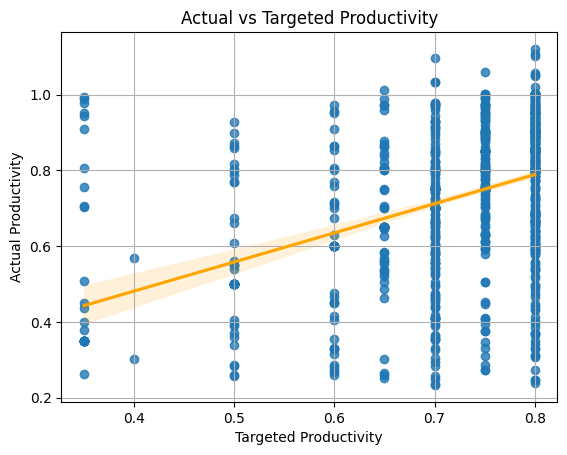

In [8]:
# scatter plot visualising actual vs targeted productivity

sns.regplot(x='targeted_productivity', y='actual_productivity', data=df, line_kws={"color": "orange"})
plt.title('Actual vs Targeted Productivity')
plt.xlabel('Targeted Productivity')
plt.ylabel('Actual Productivity')
plt.grid(True)
plt.show()

In [9]:
# correlation coefficient between targeted and actual productivity
correlation_coefficient = df['actual_productivity'].corr(df['targeted_productivity'])
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: 0.42314833010122765


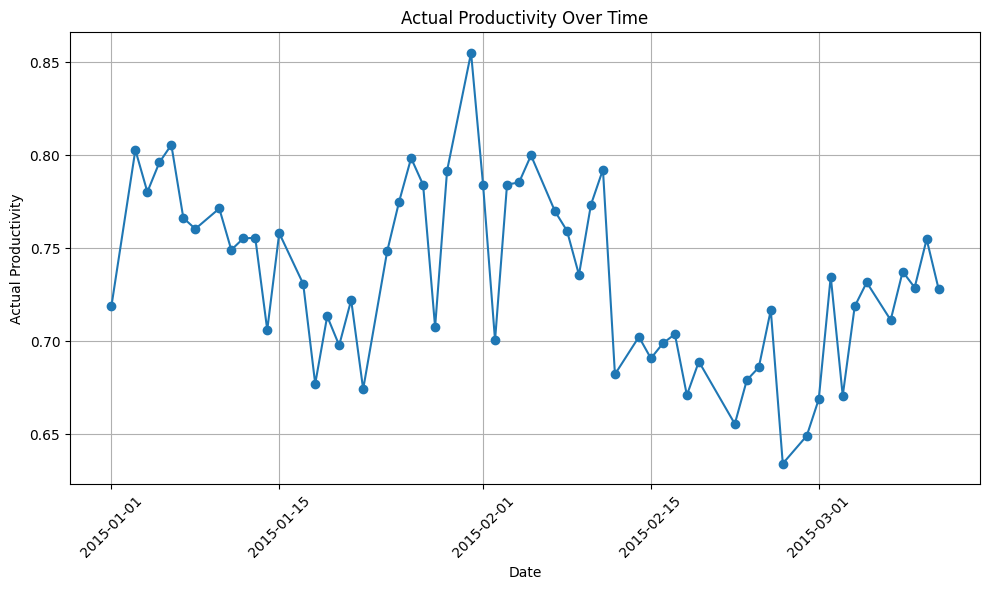

In [10]:
# actual_productivity over time
# Grouping by 'date' and calculating average of 'actual_productivity'
df_grouped = df.groupby('date')['actual_productivity'].mean().reset_index()

# converting 'date' column to datetime type
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Sorting DataFrame by date
df_grouped = df_grouped.sort_values(by='date')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['date'], df_grouped['actual_productivity'], marker='o', linestyle='-')
plt.title('Actual Productivity Over Time')
plt.xlabel('Date')
plt.ylabel('Actual Productivity')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

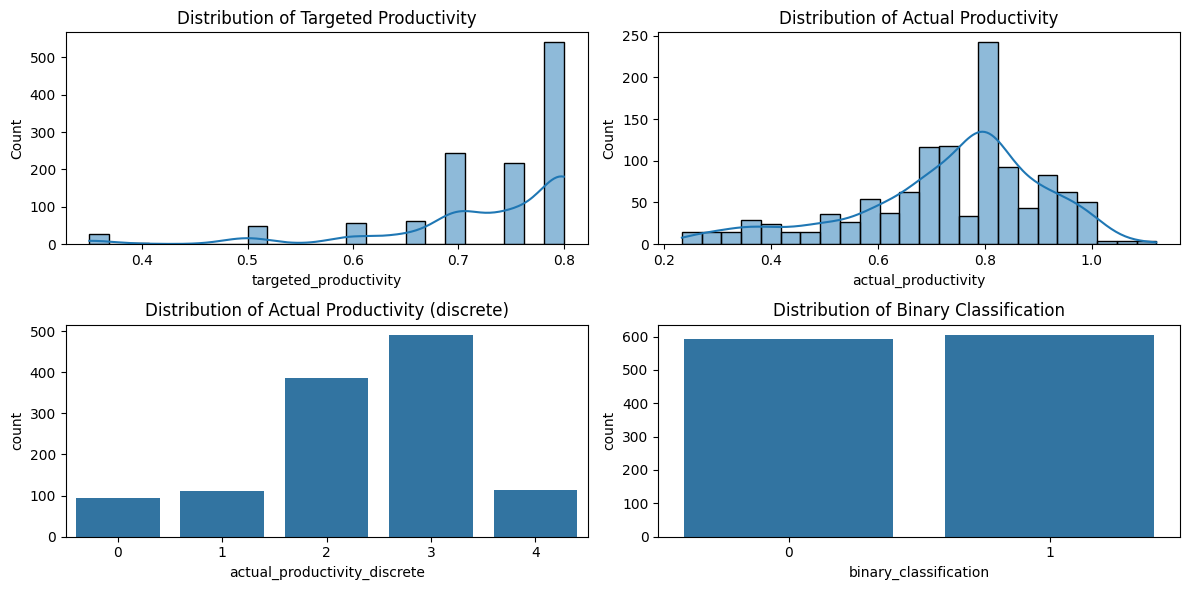

In [11]:
# visualise the distribution of features and classes

# before binning
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(df['targeted_productivity'], kde=True)
plt.title('Distribution of Targeted Productivity')

plt.subplot(2, 2, 2)
sns.histplot(df['actual_productivity'], kde=True)
plt.title('Distribution of Actual Productivity')

plt.subplot(2, 2, 3)
sns.countplot(x='actual_productivity_discrete', data=df)
plt.title('Distribution of Actual Productivity (discrete)')

plt.subplot(2, 2, 4)
sns.countplot(x='binary_classification', data=df)
plt.title('Distribution of Binary Classification')

plt.tight_layout()
plt.show()

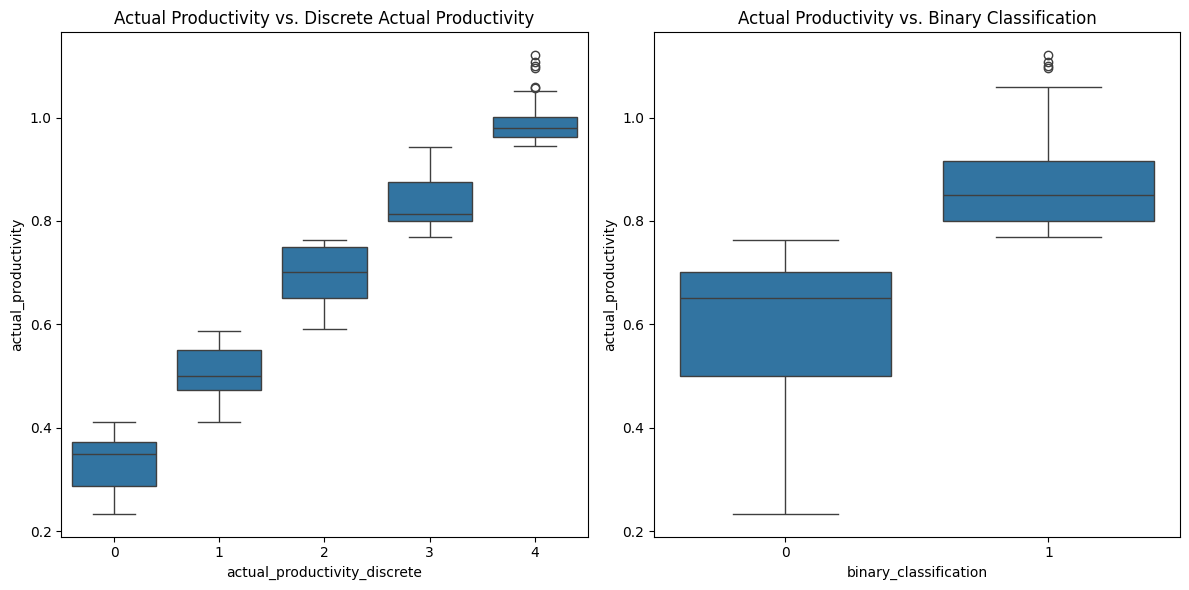

In [12]:
# after binning
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='actual_productivity_discrete', y='actual_productivity', data=df)
plt.title('Actual Productivity vs. Discrete Actual Productivity')

plt.subplot(1, 2, 2)
sns.boxplot(x='binary_classification', y='actual_productivity', data=df)
plt.title('Actual Productivity vs. Binary Classification')

plt.tight_layout()
plt.show()

In [13]:
# check for missing values
df.isna().sum()

date                              0
quarter                           0
department                        0
day                               0
team                              0
targeted_productivity             0
smv                               0
wip                             506
over_time                         0
incentive                         0
idle_time                         0
idle_men                          0
no_of_style_change                0
no_of_workers                     0
actual_productivity               0
actual_productivity_discrete      0
binary_classification             0
dtype: int64

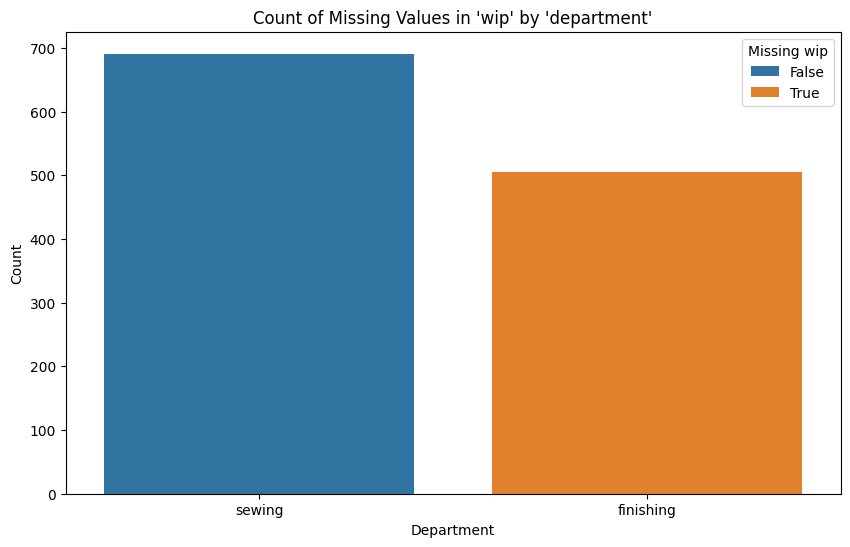

In [14]:
# wip:  : Work in progress. Includes the number of unfinished items for products.
plt.figure(figsize=(10, 6))
sns.countplot(x='department', hue=df['wip'].isna(), data=df)
plt.title("Count of Missing Values in 'wip' by 'department'")
plt.xlabel("Department")
plt.ylabel("Count")
plt.legend(title='Missing wip')
plt.show()

In [15]:
# impute missing values of wip feature with 0
df['wip'] = df['wip'].fillna(0)

In [16]:
# check data type of features
print(df.dtypes)

date                             object
quarter                          object
department                       object
day                              object
team                              int64
targeted_productivity           float64
smv                             float64
wip                             float64
over_time                         int64
incentive                         int64
idle_time                       float64
idle_men                          int64
no_of_style_change                int64
no_of_workers                   float64
actual_productivity             float64
actual_productivity_discrete      int64
binary_classification             int64
dtype: object


In [17]:
# Normalising/scaling various numerical features

# columns to be scaled
columns_to_scale = ['targeted_productivity', 'smv', 'wip','over_time','incentive','idle_time','idle_men','no_of_style_change','no_of_workers','actual_productivity']

# List of columns to be omitted from scaling
columns_to_ignore = ['quarter', 'department','day','team','actual_productivity_discrete','binary_classification']

# Extract the subset of data to be scaled
data_to_scale = df[columns_to_scale]

# Extract the subset of data to be ignored from scaling
data_to_ignore = df[columns_to_ignore]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the scaled data
scaled_data = scaler.fit_transform(data_to_scale)

# Convert the scaled array back to a DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Concatenate the scaled data with the ignored data
df_scaled = pd.concat([df_scaled, data_to_ignore], axis=1)

In [18]:
# encoding with one-hot encoding
columns_to_encode = ['quarter','department','day']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column
for column in columns_to_encode:
    df_scaled[column] = label_encoder.fit_transform(df_scaled[column])

In [19]:
df_scaled

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,quarter,department,day,team,actual_productivity_discrete,binary_classification
0,1.000000,0.450252,0.047920,0.273148,0.027222,0.0,0.0,0.0,0.655172,0.797332,0,1,3,8,3,1
1,0.888889,0.020132,0.000000,0.037037,0.000000,0.0,0.0,0.0,0.068966,0.736180,0,0,3,1,3,1
2,1.000000,0.164731,0.041865,0.141204,0.013889,0.0,0.0,0.0,0.327586,0.639274,0,1,3,11,3,1
3,1.000000,0.164731,0.041865,0.141204,0.013889,0.0,0.0,0.0,0.327586,0.639274,0,1,3,12,3,1
4,1.000000,0.445219,0.050601,0.074074,0.013889,0.0,0.0,0.0,0.620690,0.639062,0,1,3,6,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,0.888889,0.000000,0.000000,0.037037,0.000000,0.0,0.0,0.0,0.068966,0.445036,1,0,5,10,2,0
1193,0.777778,0.019357,0.000000,0.037037,0.000000,0.0,0.0,0.0,0.068966,0.441982,1,0,5,8,2,0
1194,0.666667,0.019357,0.000000,0.037037,0.000000,0.0,0.0,0.0,0.068966,0.441982,1,0,5,7,2,0
1195,0.888889,0.000000,0.000000,0.069444,0.000000,0.0,0.0,0.0,0.149425,0.306951,1,0,5,9,1,0


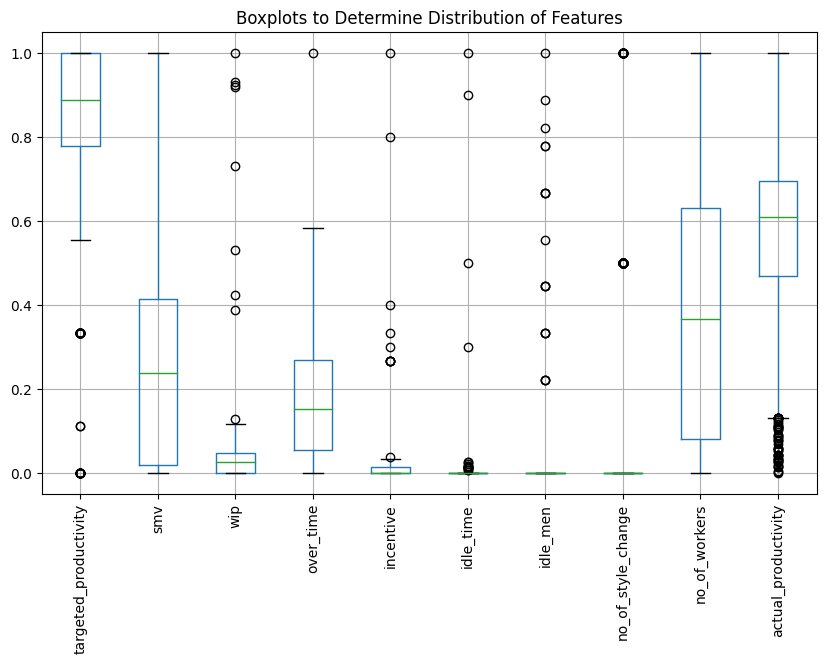

In [20]:
# boxplots that represent each column
columns_to_exclude = ['quarter', 'department','day','team','actual_productivity_discrete','binary_classification']
columns_to_plot = [col for col in df_scaled.columns if col not in columns_to_exclude]

plt.figure(figsize=(10, 6))
df_scaled[columns_to_plot].boxplot()
plt.xticks(rotation=90)
plt.title('Boxplots to Determine Distribution of Features')
plt.show()

In [21]:
# divide into training and test sets
X = df_scaled.drop(['binary_classification','actual_productivity_discrete'], axis=1)
y = df_scaled['binary_classification']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(897, 14)
(300, 14)
(897,)
(300,)


In [23]:
# Ensure y_train and y_test are in integer format
y_train = np.array(y_train)
y_test = np.array(y_test)

# Verify the initial shape and data type of y_train and y_test
print(f"Initial y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"Initial y_test shape: {y_test.shape}, dtype: {y_test.dtype}")

Initial y_train shape: (897,), dtype: int64
Initial y_test shape: (300,), dtype: int64


**B.	Developing ANN from Scratch**

**2.2	Construction of a 3-layers feedforward network**

Construction of a 3-layers feedforward network with **X input neurons**, **20 hidden neurons**, and **Y output neurons**.

In [24]:
## Activation Functions affect performance of the model

# Define Sigmoid function (f(z) = 1/(1+e⁻z))
def sigmoid(sum):
  return 1 / (1 + np.exp(-sum))

def sigmoid_derivative(sigmoid):
  return sigmoid * (1 - sigmoid)

# Define ReLU funtion (f(z) = max(0,z))
def relu(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

relu = (
  lambda x: x * (x > 0),
  lambda x:relu(x)
  )

# Define Softmax funtion (f(x) = eˣᵢ / (Σⱼ₌₀ eˣᵢ))
from numpy import exp

def softmax(vector):
 e = exp(vector)
 return e / e.sum()

In [25]:
# Initialize variables
num_input_neurons = 14
num_hidden_neurons = 20
num_output_neurons = 1

epochs = 20000
learning_rate = 0.01
error = []

weights_0 = 2 * np.random.random((num_input_neurons, num_hidden_neurons)) - 1
weights_1 = 2 * np.random.random((num_hidden_neurons,num_output_neurons)) - 1

hidden_bias = 2 * np.random.random((num_input_neurons, num_hidden_neurons)) - 1
output_bias = 2 * np.random.random((num_hidden_neurons,num_output_neurons)) - 1

hidden_activation_function = 'relu'
output_activation_function = 'sigmoid'

metrics=['accuracy']

In [26]:
# Define ANN model
def ann_model(hidden_activation_function, output_activation_function, input_shape, output_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(num_hidden_neurons, activation=hidden_activation_function, input_shape=input_shape),
        tf.keras.layers.Dense(output_shape, output_activation_function)
    ])
    return model

In [27]:
# Execute model
model = ann_model(hidden_activation_function, output_activation_function, (num_input_neurons,), num_output_neurons)
model.compile(metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                300       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**2.3	Train and test the neural network using the Backpropagation algorithm**

2.3	Write a computer program using a high-level programming language of your choice (Python with NumPy or C/C++ or Java) to train and test the neural network using the Backpropagation algorithm from scratch **WITHOUT** using any machine learning library.

**C.	Performance Evaluation**

2.4	Evaluate the NN using state-of-the-art evaluation metrics.


In [28]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

10/10 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4900
Test Loss: 0.0
Test Accuracy: 0.49000000953674316


In [29]:
def predict(X):
    return model.predict(X)

# Get predictions on test data
y_pred_class = predict(X_test)

10/10 [==============================] - 1s 5ms/step


In [30]:
# convert y_pred to binary class labels
y_pred = (y_pred_class > 0.5).astype(int)

In [31]:
### Define Confusion Matrix and Performance Evaluation Metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

def performance():
    confusion = metrics.confusion_matrix(y_test, y_pred)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    sensitivity = TP / float(FN + TP)
    specificity = TN / (TN + FP)
    false_positive_rate = FP / float(TN + FP)
    F1_score = 2*((precision*sensitivity)/(precision+sensitivity))

    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('Classification_error: ' + str(classification_error))
    print('Sensitivity: ' + str(sensitivity))
    print('Specificity: ' + str(specificity))
    print('False_positive_rate: ' + str(false_positive_rate))
    print('F1_score: ' + str(F1_score))
    print(confusion)

    # AUC and ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC score
    print("AUC Score:", roc_auc)

**20 Hidden Nuerons**

Accuracy: 0.49
Precision: 0.4916387959866221
Recall: 0.9932432432432432
Classification_error: 0.51
Sensitivity: 0.9932432432432432
Specificity: 0.0
False_positive_rate: 1.0
F1_score: 0.6577181208053691
[[  0 152]
 [  1 147]]


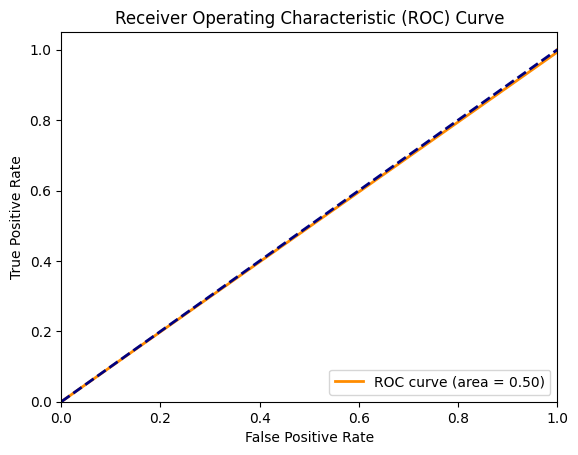

AUC Score: 0.4966216216216216


In [32]:
performance()

**D.	Performance Comparison**

**2.5 Training a new neural network classifier and evaluation performance**

2.5	Train a new neural network classifier with **10 hidden neurons** and evaluate its performance. Repeat the process for training and testing neural network classifier with **30 hidden neurons**.


**2.6 Contrast and comparrison among the performance of three trained neural network classifiers**

2.6	Contrast the differences and compare among the performance of three trained neural network classifiers (i.e., with 20, 10 and 30 hidden neurons). Justify your observations.

**10 Hidden Nuerons**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                150       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
10/10 [==============================] - 0s 8ms/step
Accuracy: 0.47
Precision: 0.4804270462633452
Recall: 0.9121621621621622
Classification_error: 0.53
Sensitivity: 0.9121621621621622
Specificity: 0.039473684210526314
False_positive_rate: 0.9605263157894737
F1_score: 0.6293706293706294
[[  6 146]
 [ 13 135]]


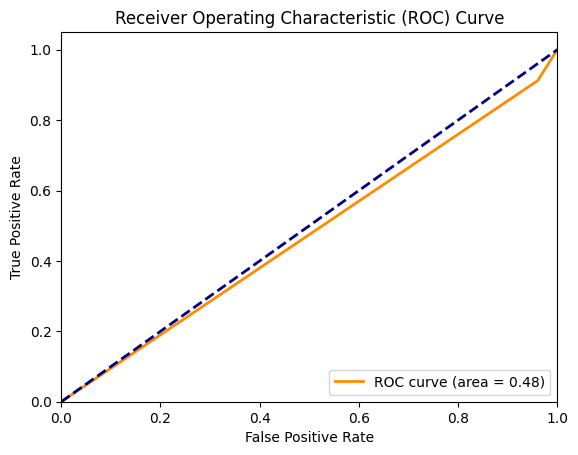

AUC Score: 0.47581792318634425


In [33]:
# update number of hidden neurons
num_hidden_neurons = 10

# update weights and bias
weights_0 = 2 * np.random.random((num_input_neurons, num_hidden_neurons)) - 1
weights_1 = 2 * np.random.random((num_hidden_neurons,num_output_neurons)) - 1

hidden_bias = 2 * np.random.random((num_input_neurons, num_hidden_neurons)) - 1
output_bias = 2 * np.random.random((num_hidden_neurons,num_output_neurons)) - 1

# execute model
model = ann_model(hidden_activation_function, output_activation_function, (num_input_neurons,), num_output_neurons)
model.compile(metrics=metrics)
model.summary()

# make class predictions for the testing set
y_pred_class = predict(X_test)
y_pred = (y_pred_class > 0.5).astype(int)

performance()

**30 Hidden Nuerons**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                450       
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
10/10 [==============================] - 0s 4ms/step
Accuracy: 0.48333333333333334
Precision: 0.4744525547445255
Recall: 0.4391891891891892
Classification_error: 0.5166666666666667
Sensitivity: 0.4391891891891892
Specificity: 0.5263157894736842
False_positive_rate: 0.47368421052631576
F1_score: 0.45614035087719296
[[80 72]
 [83 65]]


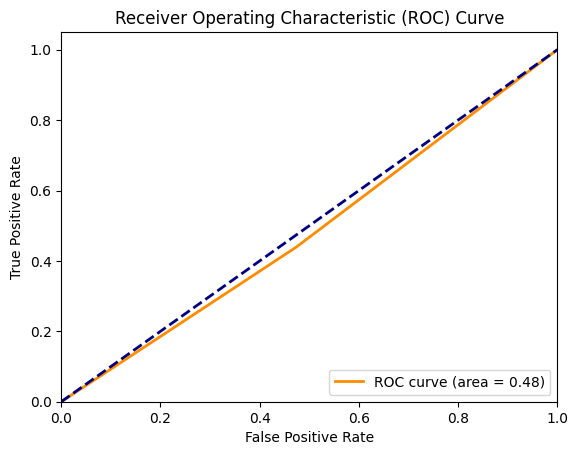

AUC Score: 0.4827524893314368


In [34]:
# update number of hidden neurons
num_hidden_neurons = 30

# update weights and bias
weights_0 = 2 * np.random.random((num_input_neurons, num_hidden_neurons)) - 1
weights_1 = 2 * np.random.random((num_hidden_neurons,num_output_neurons)) - 1

hidden_bias = 2 * np.random.random((num_input_neurons, num_hidden_neurons)) - 1
output_bias = 2 * np.random.random((num_hidden_neurons,num_output_neurons)) - 1

# Execute model
model = ann_model(hidden_activation_function, output_activation_function, (num_input_neurons,), num_output_neurons)
model.compile(metrics=metrics)
model.summary()

# make class predictions for the testing set
y_pred_class = predict(X_test)
y_pred = (y_pred_class > 0.5).astype(int)

performance()

**E.	Developing ANN using ML Libraries**

2.7	Construct, train and test a multilayer feedforward neural network, with the same datasets prepared in **step A**, using a selected machine learning library, like scikitlearn or Keras. Compare the performance of this model with the neural network classifier you trained in **step 2.2**.


Accuracy: 0.9866666666666667
Precision: 0.9864864864864865
Recall: 0.9864864864864865
Classification_error: 0.013333333333333334
Sensitivity: 0.9864864864864865
Specificity: 0.9868421052631579
False_positive_rate: 0.013157894736842105
F1_score: 0.9864864864864865
[[150   2]
 [  2 146]]


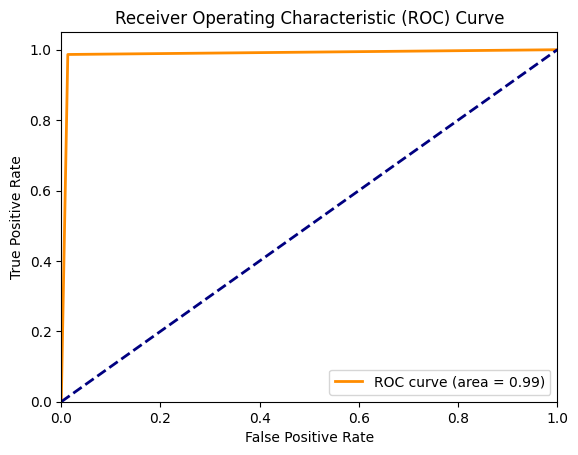

AUC Score: 0.9866642958748222


In [35]:
# Define and train the neural network classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(20,), max_iter=3000, random_state=0)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mlp_classifier.predict(X_test)

performance()

**F.	Parameter Tuning**

2.8	Tune the parameters or training rules/algorithms of your neural network model and re-train your model so that testing performance of the model is improved.


In [36]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,)],  # Number of neurons in the hidden layer
    'activation': ['relu', 'tanh','sigmoid','softmax'],               # Activation function
    'solver': ['adam', 'sgd'],                    # Solver for weight optimization
    'alpha': [0.0001, 0.001, 0.01],               # L2 penalty (regularization term)
}

# Initialize the MLP classifier
mlp_classifier = MLPClassifier(solver='adam', max_iter=1000, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(mlp_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 747, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (30,), 'solver': 'adam'}
Best Score: 0.9921973929236498
Test Accuracy: 0.9933333333333333


Accuracy: 0.9966666666666667
Precision: 0.9932885906040269
Recall: 1.0
Classification_error: 0.0033333333333333335
Sensitivity: 1.0
Specificity: 0.993421052631579
False_positive_rate: 0.006578947368421052
F1_score: 0.9966329966329966
[[151   1]
 [  0 148]]


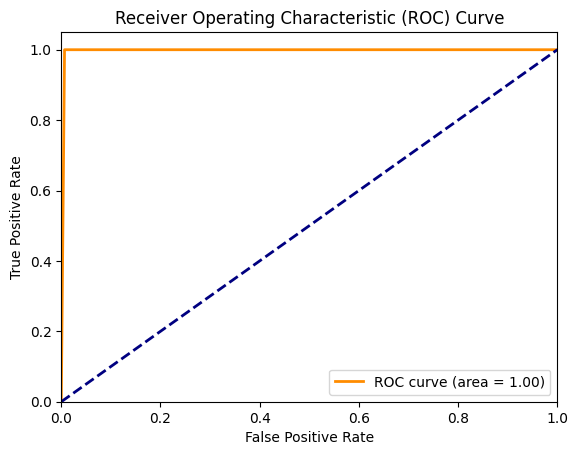

AUC Score: 0.9967105263157895


In [37]:
# Define and train the neural network classifier on best parameters
tuned_mlp_classifier = MLPClassifier(hidden_layer_sizes=(30,), activation='tanh', alpha=0.01, solver='adam', max_iter=1000, random_state=42)

tuned_mlp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tuned_mlp_classifier.predict(X_test)

performance()